## Autores: Frederico Curti e Raphael Costa

# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [3]:
%matplotlib inline
import sys
sys.path.append('..')

from random import choice
from itertools import permutations

import pandas as pd
import networkx as nx

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import socnet as sn
import math
from scipy import stats as ss

Configurando a biblioteca:

In [4]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [5]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

In [6]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [7]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [8]:
def simulate_single_flow(g, s, t, fn, transfer):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                m = fn(g, n)
            except IndexError:
                continue

            # Deixa de ser dono do insumo.
            g.nodes[n]['owner'] = not transfer

            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [9]:
def simulate_successful_flow(g, s, t, fn, transfer):
    if (fn == random_geodesic_successor):
        set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, fn, transfer)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [10]:
def simulate_all_flows(g, fn, transfer):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, fn, transfer)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

In [12]:
cc = nx.closeness_centrality(g)
bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [13]:
TIMES = 100

functions = [random_geodesic_successor, random_path_successor, random_trail_successor, random_walk_successor]
isTransfer = [True, False]
dataframes = []

g = g.copy()
for fn in functions:
    for transfer in isTransfer:
        
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] = 0
            g.nodes[n]['mean_betweenness'] = 0

        for _ in range(TIMES):
            simulate_all_flows(g, fn, transfer)

            for n in g.nodes:
                g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
                g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

        for n in g.nodes:
            g.nodes[n]['mean_closeness'] /= TIMES
            g.nodes[n]['mean_betweenness'] /= TIMES
         
        dataframes.append(pd.DataFrame({
            'família': [g.nodes[n]['label'] for n in g.nodes],
            'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
            'closeness analítico': [cc[n] for n in g.nodes],
            'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
            'betweenness analítico': [bc[n] for n in g.nodes],
            'transfer' : [transfer for n in g.nodes],
            'function' : [fn.__name__ for n in g.nodes],
        }))

In [14]:
df = pd.DataFrame()
for d in dataframes:
    df = df.append(d)

## Objetivo 3

In [16]:
g = sn.load_graph('Renaissance.gml', has_pos=True)
familias = df.família.drop_duplicates().values
data = {}

for f in range(len(familias)):
    data[familias[f]] = {
        'closeness': {},
        'betweenness': {}
    }    
    for fn in functions:
        for transfer in isTransfer:
            data[familias[f]]['betweenness'][f'{fn.__name__}_{transfer}'] = []
            data[familias[f]]['closeness'][f'{fn.__name__}_{transfer}'] = []

for fn in functions:
    for transfer in isTransfer:
        for _ in range(TIMES):
            simulate_all_flows(g, fn, transfer)

            for n in g.nodes:
                data[g.nodes[n]['label']]['betweenness'][f'{fn.__name__}_{transfer}'].append(g.nodes[n]['betweenness'])
                data[g.nodes[n]['label']]['closeness'][f'{fn.__name__}_{transfer}'].append(g.nodes[n]['closeness'])

        print('finalizou ', fn.__name__,' transfer: ', transfer)

finalizou  random_geodesic_successor  transfer:  True
finalizou  random_geodesic_successor  transfer:  False
finalizou  random_path_successor  transfer:  True
finalizou  random_path_successor  transfer:  False
finalizou  random_trail_successor  transfer:  True
finalizou  random_trail_successor  transfer:  False
finalizou  random_walk_successor  transfer:  True
finalizou  random_walk_successor  transfer:  False


In [17]:
def getFunc(name):
    if (name.split("_")[-1] == 'True'):
        return name[0:len(name) - 5]
    else:
        return name[0:len(name) - 6]

In [18]:
t_results = pd.DataFrame({
    "familia": [],
    "centralidade": [],
    "funcao": [],
    "statistic": [],
    "pvalue": []
})

for family, param in data.items():
    benchmark_bet = param['betweenness']['random_geodesic_successor_True']
    benchmark_clos = param['closeness']['random_geodesic_successor_True']
    for k, v in param.items():
        for k2, v2 in v.items():
            nested_param = k
            if (k2 != 'random_geodesic_successor_True'):
                if (nested_param == 'betweenness'):
                    statistic, pvalue = ss.ttest_ind(benchmark_bet, v2)
                else:
                    statistic, pvalue = ss.ttest_ind(benchmark_clos, v2)
                    
#                 if np.isnan(statistic):
#                     print("\n IS NAN!", benchmark_bet,'\n', v2, '\n')
                t_results = t_results.append({
                    "familia": family,
                    "centralidade": nested_param,
                    "transfer": k2.split("_")[-1] == 'True',
                    "funcao": getFunc(k2),
                    "statistic": statistic,
                    "pvalue": pvalue
                }, ignore_index=True)

In [19]:
t_results

,familia,centralidade,funcao,statistic,pvalue,transfer
0,ginori,closeness,random_geodesic_successor,0.000000,1.000000e+00,0.0
1,ginori,closeness,random_path_successor,55.891616,3.305251e-123,1.0
2,ginori,closeness,random_path_successor,95.842168,7.283876e-168,0.0
3,ginori,closeness,random_trail_successor,42.631072,1.030840e-101,1.0
4,ginori,closeness,random_trail_successor,77.096200,1.226074e-149,0.0
5,ginori,closeness,random_walk_successor,265.220481,1.344206e-254,1.0
6,ginori,closeness,random_walk_successor,101.892526,5.041266e-173,0.0
7,ginori,betweenness,random_geodesic_successor,NaN,NaN,0.0
8,ginori,betweenness,random_path_successor,NaN,NaN,1.0
9,ginori,betweenness,random_path_successor,-132.140095,4.738933e-195,0.0


E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

**DICIONÁRIO NÚMERO-FAMÍLIA**

In [23]:
df.família[0:15]

0        ginori
1     lambertes
2       albizzi
3      guadagni
4         pazzi
5      salviati
6        medici
7     tornabuon
8      bischeri
9       ridolfi
10    acciaiuol
11      strozzi
12      peruzzi
13    barbadori
14    castellan
Name: família, dtype: object

**RANKING POR CLOSENESS**
<a id="r"></a>

In [24]:
closeness_rank = []
for fn in functions:
    for transfer in isTransfer:
        r = list(df[(df.function == fn.__name__) & (df.transfer == transfer)].sort_values(by='closeness simulado').index)
#         for i in range(len(r)):
#             t_results[t_results.familia == familias[r[i]]])

        if (fn.__name__ == "random_geodesic_successor" and transfer == True):
            print('BENCHMARK:', fn.__name__, transfer)
            print(r)
            continue

        print(fn.__name__, transfer)
        print('[', end='')                
            
        for el in r:
            familia_str = familias[el]
            matching_p_value = t_results[
                (t_results.familia == familia_str) 
                 & (t_results.centralidade == 'closeness') 
                 & (t_results.funcao == fn.__name__)
                & (t_results.transfer == transfer)
            ]            
            if (matching_p_value.pvalue.values[0] > 0.05):
                print(f"\x1b[1;31m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
            elif (np.isnan(matching_p_value.pvalue.values[0])):
                print(f"\x1b[1;33m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
            else:
                print(f"\x1b[1;32m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
                
        print(']')
        
        closeness_rank.append(r)
        


BENCHMARK: random_geodesic_successor True
[4, 1, 0, 12, 10, 5, 14, 8, 11, 13, 3, 2, 7, 9, 6]
random_geodesic_successor False
[4, 1, 0, 12, 10, 5, 14, 8, 11, 13, 3, 2, 7, 9, 6]
random_path_successor True
[4, 0, 1, 12, 13, 11, 10, 5, 14, 9, 8, 7, 2, 3, 6]
random_path_successor False
[4, 5, 0, 1, 10, 12, 2, 14, 3, 8, 6, 11, 13, 9, 7]
random_trail_successor True
[4, 1, 0, 10, 14, 8, 11, 5, 9, 12, 7, 3, 13, 2, 6]
random_trail_successor False
[4, 5, 1, 0, 10, 12, 14, 8, 2, 3, 11, 6, 13, 7, 9]
random_walk_successor True
[13, 8, 11, 7, 14, 12, 9, 10, 1, 3, 6, 2, 5, 4, 0]
random_walk_successor False
[4, 0, 5, 12, 1, 14, 10, 8, 3, 2, 11, 13, 7, 9, 6]


### legenda
<span style="color: green">● p-value < 0.05 </span>

<span style="color: red">● p-value > 0.05 </span>

<span style="color: #ffcc00">● NaN </span>

**RANKING POR BETWEENNESS**

In [25]:
betweenness_rank = []
for fn in functions:
    for transfer in isTransfer:
        r = list(df[(df.function == fn.__name__) & (df.transfer == transfer)].sort_values(by='betweenness simulado').index)

        if (fn.__name__ == "random_geodesic_successor" and transfer == True):
            print('BENCHMARK:', fn.__name__, transfer)
            print(r)
            continue

        print(fn.__name__, transfer)
        print('[', end='')                
            
        for el in r:
            familia_str = familias[el]
            matching_p_value = t_results[
                (t_results.familia == familia_str) 
                 & (t_results.centralidade == 'betweenness') 
                 & (t_results.funcao == fn.__name__)
                & (t_results.transfer == transfer)
            ]            
            if (matching_p_value.pvalue.values[0] > 0.05):
                print(f"\x1b[1;31m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
            elif (np.isnan(matching_p_value.pvalue.values[0])):
                print(f"\x1b[1;33m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
            else:
                print(f"\x1b[1;32m\"{el}\"\x1b[0m".replace('"',''), end=', ' if not r.index(el) == len(r)-1 else '')
                
        print(']')
        
        betweenness_rank.append(r)

BENCHMARK: random_geodesic_successor True
[0, 1, 4, 10, 12, 11, 9, 14, 7, 13, 8, 5, 2, 3, 6]
random_geodesic_successor False
[0, 1, 4, 10, 12, 11, 14, 7, 9, 8, 13, 5, 2, 3, 6]
random_path_successor True
[0, 1, 4, 10, 5, 2, 13, 12, 7, 9, 8, 11, 14, 3, 6]
random_path_successor False
[4, 0, 10, 1, 5, 12, 13, 2, 14, 8, 7, 11, 9, 3, 6]
random_trail_successor True
[0, 1, 4, 10, 5, 12, 2, 13, 7, 11, 9, 8, 14, 3, 6]
random_trail_successor False
[4, 10, 0, 1, 5, 12, 13, 2, 8, 14, 11, 3, 9, 7, 6]
random_walk_successor True
[4, 1, 0, 10, 5, 12, 13, 14, 11, 8, 2, 9, 7, 3, 6]
random_walk_successor False
[10, 1, 4, 0, 13, 12, 5, 7, 9, 11, 8, 2, 14, 3, 6]


### legenda
<span style="color: green">● p-value < 0.05 </span>

<span style="color: red">● p-value > 0.05 </span>

<span style="color: #ffcc00">● NaN </span>

In [26]:
familias = df.família[0:15]
c_bets = []
c_closses = []
perm = []
for fn in functions:
    for transfer in isTransfer:
        perm.append((fn.__name__, transfer))
perm = perm[1:]

volatilidade = pd.DataFrame({
    'id': [],
    'familia': [],
    'volatilidade_closeness': [],
    'volatilidade_betweenness': []
})

for f in range(len(familias)):
    familia = familias[f]
    divisor_bet = 7
    divisor_clos = 7
    base_bet = betweenness_rank[0].index(f)
    base_clos = closeness_rank[0].index(f)

    c_bet = 0 
    c_clos = 0

    for r in range(len(betweenness_rank)):
        func, t = perm[r]
        matching_p_value = t_results[
            (t_results.familia == familia) 
            & (t_results.centralidade == 'betweenness')
            & (t_results.funcao == func)
            & (t_results.transfer == t)
        ]
  
        if (matching_p_value.pvalue.values[0] > 0.05) or (np.isnan(matching_p_value.pvalue.values[0])):
            divisor_bet -= 1
            
        position = betweenness_rank[r].index(f)
        c_bet += abs(base_bet - position)

    for r2 in range(len(closeness_rank)):
        func, t = perm[r2]
        matching_p_value = t_results[
            (t_results.familia == familia) 
            & (t_results.centralidade == 'closeness') 
            & (t_results.funcao == func)
            & (t_results.transfer == t)
        ]
        
#       print(matching_p_value.pvalue.values[0], matching_p_value.pvalue.values[0] > 0.05, np.isnan(matching_p_value.pvalue.values[0]))
        if (matching_p_value.pvalue.values[0] > 0.05) or (np.isnan(matching_p_value.pvalue.values[0])):
            divisor_clos -= 1
            
        position = closeness_rank[r2].index(f)
        c_clos += abs(base_clos - position)
                    
    c_bet  /= divisor_bet
    c_clos /= divisor_clos
#     print(divisor_bet, divisor_clos)
    c_bets.append(c_bet)
    c_closses.append(c_clos)
    
max_bet = max(c_bets)
max_clos = max(c_closses)

for i in range(len(c_bets)):
    c_bets[i] = round(c_bets[i]/max_bet, 3)
for i in range(len(c_closses)):
    c_closses[i] = round(c_closses[i]/max_clos, 3)
    
for f in range(len(familias)):
    volatilidade = volatilidade.append({
        'id': f,
        'familia': familias[f],
        'volatilidade_closeness': c_closses[f],
        'volatilidade_betweenness': c_bets[f]
    }, ignore_index=True)

In [27]:
def highlight(s):
    if s.pvalue > 0.05:
        return ['background-color: red']*6
    elif np.isnan(s.pvalue):
        return ['background-color: yellow']*6
    else:
        return ['background-color: white']*6
    
t_results = t_results.style.apply(highlight, axis=1)

E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

***Resposta***
Após a análise dos resultados obtidos, foi possível corroborar a seguinte hipótese: se modificarmos o tipo de trajetória e considerarmos outros tipos de difusão, os nós com maior closeness simulado e betweenness simulado não serão necessariamente os nós com maior closeness e betweenness segundo as fórmulas clássicas. Essas medidas de centralidade (closeness e betweenness) representam, respecivamente, o quão próximo um nó está dos outros em uma rede, e a quantidade de menores caminhos de todos os vértices para quaisquer outros vértices que passam por aquele nó. Essas medidas são importantes, pois ajudam a definir o quão influente um nó é naquela rede. Sendo assim, considerando o contexto de casamento entre famílias italianas do período Renascentista, pode-se, através desta analise, reconstruir uma parte do cenário político e social da epóca para entender melhor como essas famílias contribuíram no desenvolvimento de acontecimentos históricos entre os séculos XIV e XVII. </br>

Os métodos clássicos para o cálculo de tais medidas envolvem simulações nas quais sempre é adotado um tipo específico de caminho e difusão, utilizando o caminho geodésico e difusão por transferência. Isto implica que a simualção leva em consideração apenas os menores caminhos possíveis e relações onde ocorre transferência de propriedade. No entanto, este cenáro nem sempre representa o comportamento real da rede. Por exemplo, as transferências monetárias que ocorriam entre essas famílias dificilmente seguiriam o menor caminho possível, da mesma forma como uma fofoca, ao ser contada, não implica na perda desta informção pela pessoa que a contou. Portanto, considerar outros tipos de caminho e de difusão poderiam alterar significativamente a percepção de poder e influência nessas famílias. </br>

Para verificar tal hipótese, foi proposta a realização de uma série de testes T, a fim de comparar amostras aleatórias que se valiam de uma permutação entre outros tipos de caminho (caminho, passeio e trilha) e difusão (transferência ou duplicação) com o benchmark dos métodos clássicos. Estes testes T nos permitem obter um p-valor, que indica a probabilidade de obter um valor da estatística de teste como o observado. Ou seja, um p-valor muito pequeno indica que é muito improvável que o resultado de cada simulação seja igual ao do benchmark. Tipicamente, assume-se uma margem de tolerância de 5%, assim, um p-valor menor que 0.05 nos permite reijeitar a hipótese nula com relativa segurança. </br>

Na tabela abaixo, estão os p-values para todos os testes realizados com as médias de closeness e betweenness para cada tipo de caminho e difusão em relação ao benchamark. Ao longo da análise, as medidas de centralidade foram analisadas de forma independente. 

In [28]:
t_results

,familia,centralidade,funcao,statistic,pvalue,transfer
0,ginori,closeness,random_geodesic_successor,0,1,0
1,ginori,closeness,random_path_successor,55.8916,3.30525e-123,1
2,ginori,closeness,random_path_successor,95.8422,7.28388e-168,0
3,ginori,closeness,random_trail_successor,42.6311,1.03084e-101,1
4,ginori,closeness,random_trail_successor,77.0962,1.22607e-149,0
5,ginori,closeness,random_walk_successor,265.22,1.34421e-254,1
6,ginori,closeness,random_walk_successor,101.893,5.04127e-173,0
7,ginori,betweenness,random_geodesic_successor,nan,nan,0
8,ginori,betweenness,random_path_successor,nan,nan,1
9,ginori,betweenness,random_path_successor,-132.14,4.73893e-195,0


Em amarelo, estão os testes em que o p-value não pode ser calculado por falha na simulação e, em vermelho, aqueles em que o p-value encontrado é maior que 5%. Sendo assim, são os únicos em que não podemos afirmar que houve mudança significativa.

Ao ordenar as famílias pelas medidas de centralidade de forma crescente, observou-se que a hierarquia mudava consistemente para os testes nos quais rejeitamos a hipótese nula. Para facilitar a visualização destas mudanças na posição, foi um criado um parâmetro chamado de volatilidade. Esta medida indica o quão propensa uma família esta a mudar de posição nas simulações ao alterar seus parâmetros. Desta forma, uma volatilidade 0 indica que a família permanceu na mesma posição na hierarquia para todos os testes em comparação ao benchmark; enquanto que uma volatilidade 1 indica a família que mais mudou de posição, sendo a mudança tanto para o topo quanto para a base da hierarquia. O cálculo desse parâmetro foi realizado acumulando a diferença da posição de cada família para cada mudança dos parâmetros da simulação em relação à sua posição no benchmark, dividindo esse acúmulo pelo número de valores válidos. Valores considerados válidos são aqueles nos quais o pvalue é menor que 0.05 e não é <code>nan</code>, ou seja, são mudanças de posições confiáveis estatisticamente

Caso queira visualizar o ranking absoluto das famílias para cada teste, basta subir até a sessão de **RANKING POR CLOSENESS** e **RANKING POR BETWEENNESS** ou [clique aqui](#r)

***Tabela de volatilidade para closeness***

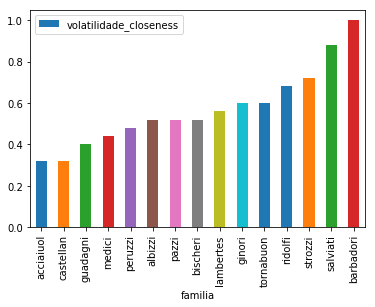

In [29]:
volatilidade.sort_values(by='volatilidade_closeness').plot(kind = 'bar', x='familia', y='volatilidade_closeness')

***Tabela de volatilidade para betweenness***

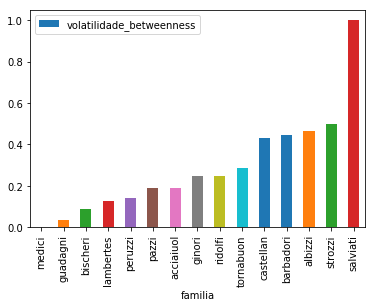

In [30]:
volatilidade.sort_values(by='volatilidade_betweenness').plot(kind = 'bar', x='familia', y='volatilidade_betweenness')

Por fim, foi possível observar que algumas famílias mudam drasticamente de posição na hierarquia quando consideradas outras formas de simulação. Podemos, agora, definir com mais segurança a verdadeira influência destas famílias, por exemplo, uma família que apresentou uma volatilidade baixa, provavelmente está naquela posição real da hierarquia, enquanto que uma muito volátil pode ser menos ou mais influente do que se esperaria baseando-se nos testes clássicos.